# Python for Trading

This document explains how to optimize your portfolio and get another suggestions based on different theories and equations, and other **interesting** things.<br>


# <center>Portfolio Optimization</center>

Resources:
- [An Introduction to Portfolio Optimization in Python](https://builtin.com/data-science/portfolio-optimization-python)
- [Portfolio Optimization with Python using Efficient Frontier](https://www.machinelearningplus.com/machine-learning/portfolio-optimization-python-example/#4-modern-portfolio-theory-mpt-)
- [Portfolio Optimization Using mpt in Python](https://www.analyticsvidhya.com/blog/2021/04/portfolio-optimization-using-mpt-in-python/)

1. <font color='red'>What is portfolio optimization?</font>
Portfolio optimization is the process of creating a portfolio of assets, for which your investment has the maximum return and minimum risk.
2. <font color='red'>What does a portfolio mean?</font>
An investor’s portfolio basically is his/her investment in different kinds of assets from different companies.
3. <font color='red'>What are assets, returns and risk?</font>
Assets are of various kinds. An asset is what you would purchase if you want to invest in a company.<br>
This profit is what we call **returns**.<br>
But what if the company whose stocks you have purchased goes bankrupt?<br>
This will lead to its stocks crashing in the share market and instead of gaining profits, you will also lose your capital investment.<br>
This is what is called **risk** of investment.
4. <font color='orange'>**Modern Portfolio Theory (MPT)**</font>
Modern Portfolio Theory, or also known as mean-variance analysis is a mathematical process which allows the user to maximize returns for a given risk level.
5. <font color='red'>What is Efficient Frontier?</font>
Efficient frontier is a graph with ‘returns’ on the Y-axis and ‘volatility’ on the X-axis. It shows the set of optimal portfolios that offer the highest expected return for a given risk level or the lowest risk for a given level of expected return.<br>
Portfolios that lie outside the efficient frontier are sub-optimal because they do not provide either enough return for the level of risk or have a higher risk for the defined rate of return.

In each of these cases, the task of optimizing assets involves balancing the trade-offs between risk and return, where return on a stock is the profits realized after a period of time and risk is the standard deviation in an asset's value.

<font color='orange'>*The idea here is that having a portfolio of different types of assets is less risky than having ones that are similar.*</orange>

In [1]:
import yfinance
# from yahoofinancials import YahooFinancials
import mplfinance as mpf
import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.stats as stats
from matplotlib import pyplot as plt
import seaborn  as sns
from plotly import express as px
import datetime as dt
import os
# -----------------------------------------
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 1000
pd.options.display.max_columns = 1000
#-------------------------------------------
sns.set()

# *Downloading Data from* <font color='purple'>Yahoo!</font>
1- Using `yf.download` <br>
2- Using `yfinance.Ticker(['list of stock names']).history('args')`<br>
3- Using `pandas_data_reader`<br>

[List of SP500 Companies](https://www.liberatedstocktrader.com/sp-500-companies/)

*Define stock names, Start date, End date, and interval*

In [2]:
stocknames = ['MSFT','AAPL', 'SPY', 'GLD', 'BTC-USD', '^N225', 'CL=F']
startdate = '2019-01-01'
enddate =   dt.datetime.now().date()
# enddate = '2019-12-31'
interval = '1d'

downloading data using Using yf.download

In [4]:

for stock in stocknames:
    path = 'D:/DA/'+stock+'.csv'  # Change to your path or use another method to download the stock files from yahoo as mentioned in Part one
    if os.path.isfile(path) == False:
        df = yfinance.download(stock, interval= interval, period='max')
        df.to_csv('{}.csv'.format(stock))

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
# Functions
def appending(cols=[], startdate = '', enddate = ''):
    '''append stocks data into one file and then select the Adj Close column'''
    global df
    dates = pd.date_range(start= startdate, end= enddate)
    df = pd.DataFrame(index= dates)
    for stock in stocknames:
        df_symbols = pd.read_csv(os.path.join('{}.csv'.format(stock)), index_col='Date', parse_dates=True, usecols=cols, na_values=['NaN'])
        df_symbols = df_symbols.rename(columns={'Adj Close' : stock})
        df = df.join(df_symbols)
        df = df.loc[dates]
    df = df.dropna()
    return df

In [6]:
appending(['Date', 'Adj Close'], startdate, enddate)
df.index.names = ['Date']
df.head()

,MSFT,AAPL,SPY,GLD,BTC-USD,^N225,CL=F
Date,,,,,,,
2019-01-07,98.49,35.86,241.85,121.86,"4,025.25","20,038.97",51.59
2019-01-28,101.40,37.88,250.77,123.29,"3,470.45","20,649.00",55.26
2019-02-04,102.04,41.51,258.57,123.96,"3,459.15","20,883.77",52.72
2019-02-25,108.14,42.41,265.75,125.37,"3,882.70","21,528.23",55.80
2019-03-04,108.79,42.81,265.64,121.56,"3,761.56","21,822.04",56.07


In [7]:
df = df.rename(columns={'BTC-USD' : 'BTC', '^N225' : 'JPN', 'CL=F' : 'OIL'})
df.head()

,MSFT,AAPL,SPY,GLD,BTC,JPN,OIL
Date,,,,,,,
2019-01-07,98.49,35.86,241.85,121.86,"4,025.25","20,038.97",51.59
2019-01-28,101.40,37.88,250.77,123.29,"3,470.45","20,649.00",55.26
2019-02-04,102.04,41.51,258.57,123.96,"3,459.15","20,883.77",52.72
2019-02-25,108.14,42.41,265.75,125.37,"3,882.70","21,528.23",55.80
2019-03-04,108.79,42.81,265.64,121.56,"3,761.56","21,822.04",56.07


### Hierarchical Risk Parity (HRP)<br>
The HRP method works by finding subclusters of similar assets based on returns and constructing a hierarchy from these clusters to generate weights for each asset. <br>
HRP does not require inverting of a covariance matrix, which is a measure of how stock returns move in the same direction.<br>
HRP is not as sensitive to outliers.

In [8]:
daily_returns = df.pct_change().dropna()

In [9]:
from pypfopt import HRPOpt
# run the optimization algorithm to get the weights:
hrp = HRPOpt(daily_returns)
hrp_weights = hrp.optimize()

# performance of the portfolio and the weights:
hrp.portfolio_performance(verbose=True)
hrp_weights = dict(hrp_weights)
print(hrp_weights)

Expected annual return: 136.1%
Annual volatility: 33.5%
Sharpe Ratio: 4.00
{'AAPL': 0.07775531025348303, 'BTC': 0.018220997463075015, 'GLD': 0.47675808184028967, 'JPN': 0.15696173317777115, 'MSFT': 0.08901986852414509, 'OIL': 0.0344458952943232, 'SPY': 0.1468381134469128}


In [10]:
sum(hrp_weights.values())

1.0

Finally, let’s calculate the discrete allocation using our weights:

In [11]:
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
latest_prices = get_latest_prices(df)
da_hrp = DiscreteAllocation(hrp_weights, latest_prices, total_portfolio_value=10000)

allocation, leftover = da_hrp.greedy_portfolio()
print("Discrete allocation (HRP):", allocation)
print("Funds remaining (HRP): ${:.2f}".format(leftover))

Discrete allocation (HRP): {'GLD': 27, 'SPY': 3, 'MSFT': 3, 'AAPL': 4, 'OIL': 3}
Funds remaining (HRP): $2133.06


### Mean Conditional Value at Risk (mCVAR)
The mCVAR is another popular alternative to mean variance optimization. It works by measuring the worst-case scenarios for each asset in the portfolio, which is represented here by losing the most money. The worst-case loss for each asset is then used to calculate weights to be used for allocation for each asset. <br>

Calculate the weights and get the performance:

In [12]:
from pypfopt.efficient_frontier import EfficientCVaR
from pypfopt.expected_returns import mean_historical_return

mu= mean_historical_return(df)
S = df.cov()
ef_cvar = EfficientCVaR(mu, S)
cvar_weights = ef_cvar.min_cvar()

cleaned_weights = ef_cvar.clean_weights()
print(dict(cleaned_weights))
round(np.mean(ef_cvar.expected_returns) *100,2)

{'MSFT': 0.0, 'AAPL': 0.0, 'SPY': 0.0, 'GLD': 0.0, 'BTC': 1.0, 'JPN': 0.0, 'OIL': 0.0}


2090.67

Next, get the discrete allocation:

In [13]:
np.seterr(invalid= 'ignore')
da_cvar = DiscreteAllocation(cvar_weights, latest_prices, total_portfolio_value=10000)
allocation, leftover = da_cvar.greedy_portfolio()
print("Discrete allocation (CVAR):", allocation)
print("Funds remaining (CVAR): ${:.2f}".format(leftover))

Discrete allocation (CVAR): {'SPY': 1, 'MSFT': 1, 'AAPL': 1}
Funds remaining (CVAR): $9097.71


----------------------------------

*Portfolio expected returns*<br>
The mean of returns (given by change in prices of asset stock prices) give us the expected returns of that asset.
The sum of all individual expected returns further multiplied by the weight of assets give us expected return for the portfolio.

Note that we use the resample() function to get yearly returns. The argument to function, ‘Y’, denotes yearly.

In [14]:
# Yearly returns for individual companies
ind_er = df.resample('Y').last().pct_change().mean()
ind_er.to_frame()

,0
MSFT,0.28
AAPL,0.39
SPY,0.13
GLD,0.08
BTC,1.14
JPN,0.05
OIL,0.18


In [15]:
# Volatility is given by the annual standard deviation. We multiply by 250 because there are 250 trading days/year.
ann_sd = df.pct_change().apply(lambda x: np.log(1+x)).std().apply(lambda x: x*np.sqrt(252))
ann_sd

MSFT   0.67
AAPL   0.77
SPY    0.52
GLD    0.37
BTC    1.87
JPN    0.55
OIL    1.37
dtype: float64

In [16]:
assets = pd.concat([ind_er, ann_sd], axis=1) # Creating a table for visualising returns and volatility of assets
assets.columns = ['Returns', 'Volatility']
assets

,Returns,Volatility
MSFT,0.28,0.67
AAPL,0.39,0.77
SPY,0.13,0.52
GLD,0.08,0.37
BTC,1.14,1.87
JPN,0.05,0.55
OIL,0.18,1.37


Next, to plot the graph of efficient frontier, we need run a loop. In each iteration, the loop considers different weights for assets and calculates the return and volatility of that particular portfolio combination.

We run this loop a 1000 times.

To get random numbers for weights, we use the np.random.random() function. But remember that the sum of weights must be 1, so we divide those weights by their cumulative sum.

In [17]:

p_ret = [] # Define an empty array for portfolio returns
p_vol = [] # Define an empty array for portfolio volatility
p_weights = [] # Define an empty array for asset weights

num_assets = len(df.columns)
num_portfolios = 10000

# Log of percentage change
cov_matrix = daily_returns.cov()

In [18]:
for portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights = weights/np.sum(weights)
    p_weights.append(weights)
    returns = np.dot(weights, ind_er) # Returns are the product of individual expected returns of asset and its 
                                      # weights 
    p_ret.append(returns)
    var = cov_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum()# Portfolio Variance
    sd = np.sqrt(var) # Daily standard deviation
    ann_sd = sd*np.sqrt(250) # Annual standard deviation = volatility
    p_vol.append(ann_sd)

In [19]:
data = {'Returns':p_ret, 'Volatility':p_vol}

for counter, symbol in enumerate(df.columns.tolist()):
    #print(counter, symbol)
    data[symbol+' weight'] = [w[counter] for w in p_weights]
portfolios  = pd.DataFrame(data)

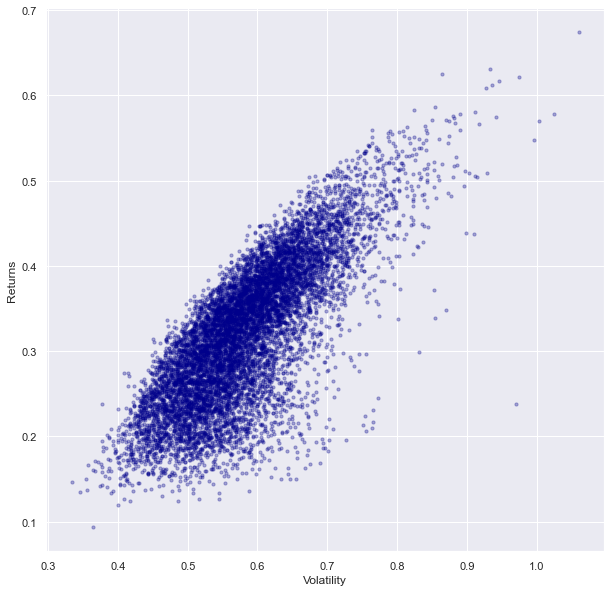

In [20]:
# Plot efficient frontier
portfolios.plot.scatter(x='Volatility', y='Returns', marker='o', s=10, alpha=0.3, grid=True, figsize=[10,10], color='darkblue');

In [21]:
min_vol_port = portfolios.iloc[portfolios['Volatility'].idxmin()]
# idxmin() gives us the minimum value in the column specified.                               
min_vol_port

Returns       0.15
Volatility    0.33
MSFT weight   0.13
AAPL weight   0.03
SPY weight    0.11
GLD weight    0.54
BTC weight    0.02
JPN weight    0.10
OIL weight    0.06
Name: 5943, dtype: float64

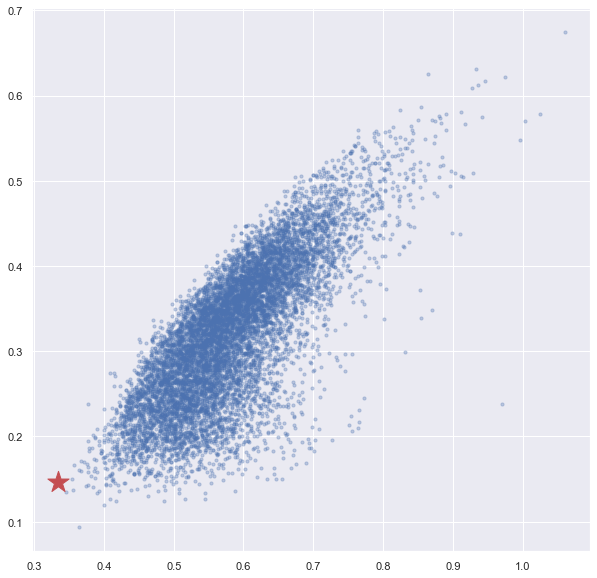

In [22]:
# plotting the minimum volatility portfolio
plt.subplots(figsize=[10,10])
plt.scatter(portfolios['Volatility'], portfolios['Returns'],marker='o', s=10, alpha=0.3)
plt.scatter(min_vol_port[1], min_vol_port[0], color='r', marker='*', s=500);

In [23]:
# Finding the optimal portfolio
rf = 0.01 # risk factor
optimal_risky_port = portfolios.iloc[((portfolios['Returns']-rf)/portfolios['Volatility']).idxmax()]
optimal_risky_port

Returns       0.45
Volatility    0.59
MSFT weight   0.08
AAPL weight   0.35
SPY weight    0.06
GLD weight    0.27
BTC weight    0.23
JPN weight    0.01
OIL weight    0.01
Name: 8396, dtype: float64

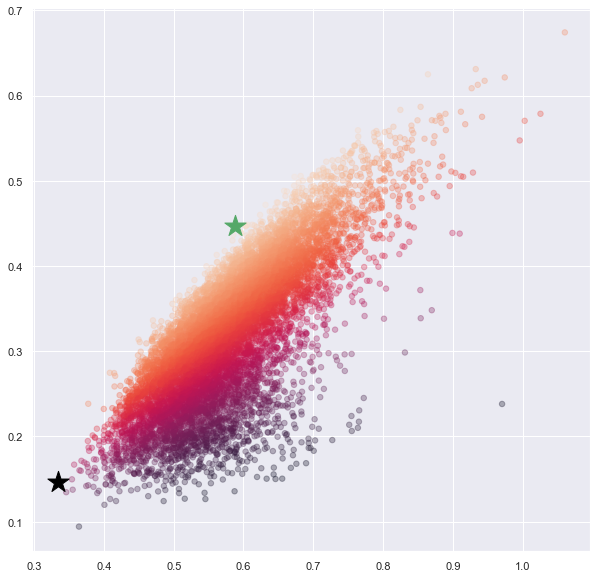

In [24]:
# Plotting optimal portfolio
plt.subplots(figsize=(10, 10))
sharpe_err = portfolios['Returns'] / portfolios['Volatility']
plt.scatter(portfolios['Volatility'], portfolios['Returns'], c=sharpe_err, s=30, alpha=0.3,)
plt.scatter(min_vol_port[1], min_vol_port[0], color='black', marker='*', s=500)
plt.scatter(optimal_risky_port[1], optimal_risky_port[0], color='g', marker='*', s=500);

--------------------------

Calculate the CAGR, returns, and covariance
To calculate the expected return, we use the Compound Average Growth Rate (CAGR) based on the last 5 years. The CAGR is used as investopedia suggest. An alternative that also is being used is the mean of the returns. The key thing is to have some common measure of the return.

The CAGR is calculated as follows.

$$CAGR = (end-price/start-price)^(1/years) – 1$$

We will also calculate the covariance as we will use that the calculate the variance of a weighted portfolio. Remember that the standard deviation is given by the following.

sigma = sqrt(variance)

A portfolio is a vector w with the balances of each stock. For example, given `w = [0.2, 0.3, 0.4, 0.1]`, will say that we have 20% in the first stock, 30% in the second, 40% in the third, and 10% in the final stock. It all sums up to 100%.

Given a weight w of the portfolio, you can calculate the variance of the stocks by using the covariance matrix.

$$variance = w^T Cov w$$

Where Cov is the covariance matrix.

In [27]:
returns = df/df.shift(1)
years = 3
cagr = (df.iloc[-1]/df.iloc[0])**(1/years) - 1
cov = returns.cov()
print(cagr)


MSFT   0.44
AAPL   0.68
SPY    0.22
GLD    0.13
BTC    1.20
JPN    0.11
OIL    0.21
dtype: float64


In [28]:
print(cov)

      MSFT  AAPL  SPY   GLD  BTC  JPN  OIL
MSFT  0.00  0.00 0.00  0.00 0.00 0.00 0.00
AAPL  0.00  0.00 0.00 -0.00 0.00 0.00 0.00
SPY   0.00  0.00 0.00  0.00 0.00 0.00 0.00
GLD   0.00 -0.00 0.00  0.00 0.00 0.00 0.00
BTC   0.00  0.00 0.00  0.00 0.01 0.00 0.00
JPN   0.00  0.00 0.00  0.00 0.00 0.00 0.00
OIL   0.00  0.00 0.00  0.00 0.00 0.00 0.01


Plot the return and risk
This is where the power of computing comes into the picture. The idea is to just try a random portfolio and see how it rates with regards to expected return and risk.

It is that simple. Make a random weighted distribution of your portfolio and plot the point of expected return (based on our CAGR) and the risk based on the standard deviation calculated by the covariance.

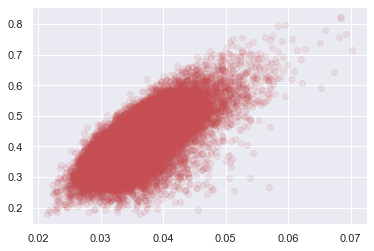

In [26]:
def random_weights(n):
    k = np.random.rand(n)
    return k / sum(k)
exp_return = []
sigma = []
for _ in range(20000):
  w = random_weights(len(df.columns))
  exp_return.append(np.dot(w, cagr.T))
  sigma.append(np.sqrt(np.dot(np.dot(w.T, cov), w)))
plt.plot(sigma, exp_return, 'ro', alpha=0.1) 
# plt.plot(min_vol_port[1], min_vol_port[0], color='black', marker='*', s=500)
# plt.plot(optimal_risky_port[1], optimal_risky_port[0], color='g', marker='*', s=500);
plt.show();